# Environment setup

In [231]:
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import requests
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import numpy as np
import pandas as pd
import patsy
import scipy.stats as stats
from scipy.stats import boxcox 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import lars_path
pd.set_option("display.max_columns", None)
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

In [135]:
dfp = pd.read_csv("stats.csv")
dfp.drop(dfp.iloc[:,0:1], axis=1, inplace=True)
dfs = pd.read_csv("salaries.csv")
dfs.drop(dfs.iloc[:,0:1],axis=1, inplace=True)

In [136]:
teamdict = {'Golden State Warriors':'GSW','Washington Wizards':'WAS', 'Oklahoma City Thunder':'OKC',\
            'Portland Trail Blazers':'POR', 'Cleveland Cavaliers':'CLE', 'Milwaukee Bucks':'MIL',\
            'Indiana Pacers':'IND', 'San Antonio Spurs':'SAS', 'Chicago Bulls':'CHI', 'Orlando Magic':'ORL',\
            'New Orleans Pelicans':'NOP', 'Utah Jazz':'UTA','New York Knicks':'NYK','Phoenix Suns':'PHO',\
            'Minnesota Timberwolves':'MIN','Philadelphia 76ers':'PHI','Denver Nuggets':'DEN',\
            'Toronto Raptors':'TOR','New Orleans Hornets':'NOH','Brooklyn Nets':'BKN','Los Angeles Clippers':'LAC',\
            'Los Angeles Lakers':'LAL','Sacramento Kings':'SAC','Miami Heat':'MIA','Boston Celtics':'BOS',\
            'Atlanta Hawks':'ATL','Houston Rockets':'HOU','Charlotte Bobcats':'CHA','Memphis Grizzlies':'MEM',\
            'New Jersey Nets':'NJN','Detroit Pistons':'DET','Charlotte Hornets':'CHO','Dallas Mavericks':'DAL'}

In [137]:
dfs['team'] = dfs.team.map(teamdict)
dfp['season'] = pd.to_numeric(dfp['season'])
df = dfp.merge(dfs, on=["player_name","season","team"], how='left')
df.replace('',np.nan, inplace=True)

In [138]:
df.shape

(4691, 33)

In [139]:
df.dropna(subset=['salary','team'], inplace=True)
df.drop(index=4040,inplace=True)

In [140]:
df.shape

(2846, 33)

In [141]:
def heighttoinch(x):
    return int(x.split('-')[0])*12 + int(x.split('-')[1])
df["height_in"] = df.height.apply(heighttoinch)

def cleanweight(x):
    return int(x.split('lb')[0])
df["weight_lbs"] = df.weight.apply(cleanweight)

def salaryclean(x):
    return x.split('$')[1]
df["salaryusd"] = df.salary.apply(salaryclean)

def salaryclean2(x):
    return x.replace(',','').split('.00')[0]
df["salary_usd"] = df.salaryusd.apply(salaryclean2)

In [142]:
df.drop(df[df['salary_usd']=="Minimum"].index,axis=0, inplace=True)
df.fillna(0, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')

In [143]:
awards = pd.read_csv("awards.csv")
season_rec = pd.read_csv("season_record_team.csv")
playoff_rec = pd.read_csv("playoff_record_team.csv")
# dfs.drop(dfs.iloc[:,0:1],axis=1, inplace=True)

In [144]:
dfd = df.merge(awards, on=["player_name","season"], how='left')
dfd = dfd.merge(season_rec, on=["team","season"], how='left')
dfd = dfd.merge(playoff_rec, on=["team","season"], how='left')

In [611]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2791 entries, 0 to 2790
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_name     2791 non-null   object 
 1   height          2791 non-null   object 
 2   weight          2791 non-null   object 
 3   season          2791 non-null   float64
 4   age             2791 non-null   float64
 5   team            2791 non-null   object 
 6   pos             2791 non-null   object 
 7   gameplayed      2791 non-null   float64
 8   gamestarted     2791 non-null   float64
 9   minpergame      2791 non-null   float64
 10  fgmade          2791 non-null   float64
 11  fgattempt       2791 non-null   float64
 12  fgpct           2791 non-null   float64
 13  threemade       2791 non-null   float64
 14  threeattempt    2791 non-null   float64
 15  threepct        2791 non-null   float64
 16  twomade         2791 non-null   float64
 17  twoattempt      2791 non-null   f

In [561]:
dfd.fillna(0,inplace=True)
# dfd["def_stat"] = dfd["steals"] + dfd["blocks"]
# dfd["off_eff"] = dfd["assist"]+dfd["fgmade"]-dfd["turnov"]
# dfd["starter"] = dfd["gamestarted"] / dfd['gameplayed']
dfd["salary_log"] = np.log10(dfd.salary_usd)
dfd["playoff_record"] = dfd['finals']*4+dfd['conf_fin']*3+dfd['conf_semi']*2+dfd['conf_first']

dfmain = dfd.drop(["player_name","height","weight","team","salary","salaryusd"\
                  ,'starter','threeattempt','threepct','MVP','ROTY','PTS','REBS','ASS','WINSHARES'\
                  ,'twoattempt','weight_lbs','twopct','ftattempt','fgattempt','allreb'\
                  ,'fgpct','finals','twomade','threemade','ftmade','fgmade','gamestarted'\
                  ,'conf_fin','conf_semi','conf_first','season','champ'], axis=1)

mask = (dfmain["pts_pg"]!=0)
dfmain = dfmain[mask]

mask = (dfmain['ftpct']>=0.1)
dfmain = dfmain[mask]

mask = (dfmain["gameplayed"]>10)
dfmain = dfmain[mask]

dfmain['min_interact'] = dfmain['minpergame'] * (dfmain['minpergame']<25)
dfmain['age_young'] = dfmain['age'] * (dfmain['age']< 23)
dfmain['age_mid'] = dfmain['age'] * ((dfmain['age'] >= 23) & (dfmain['age'] < 27))
dfmain['age_exp'] = dfmain['age'] * ((dfmain['age'] >= 27) & (dfmain['age'] < 32))
dfmain['age_vet'] = dfmain['age'] * (dfmain['age']>= 32)

dfmain['drpmin'] = dfmain['defreb'] / dfmain['minpergame']
dfmain['orpmin'] = dfmain['offreb'] / dfmain['minpergame']
dfmain['ptpmin'] = dfmain['points'] / dfmain['minpergame']
dfmain['topmin'] = dfmain['turnov'] / dfmain['minpergame']
dfmain['aspmin'] = dfmain['assist'] / dfmain['minpergame']
dfmain['stpmin'] = dfmain['steals'] / dfmain['minpergame']
dfmain['blpmin'] = dfmain['blocks'] / dfmain['minpergame']
dfmain['pfpmin'] = dfmain['pfouls'] / dfmain['minpergame']

dfmain = dfmain.drop(['defreb','offreb','points','turnov','assist','steals','blocks','pfouls'], axis=1)
dfmain = dfmain.drop(['off_eff','def_stat','shotsmade'], axis=1)
dfmain.drop_duplicates(subset=['efgpct','age','gameplayed','minpergame','ftpct'], keep='last')

dfmain.to_csv("dfmain.csv")

In [562]:
dfmain.info()
dfmain.head()
dfmain.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666 entries, 0 to 2790
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2666 non-null   float64
 1   pos             2666 non-null   object 
 2   gameplayed      2666 non-null   float64
 3   minpergame      2666 non-null   float64
 4   efgpct          2666 non-null   float64
 5   ftpct           2666 non-null   float64
 6   height_in       2666 non-null   int64  
 7   salary_usd      2666 non-null   int64  
 8   wl_pct          2666 non-null   float64
 9   pts_pg          2666 non-null   float64
 10  opp_pts_pg      2666 non-null   float64
 11  simple_rating   2666 non-null   float64
 12  salary_log      2666 non-null   float64
 13  playoff_record  2666 non-null   float64
 14  min_interact    2666 non-null   float64
 15  age_young       2666 non-null   float64
 16  age_mid         2666 non-null   float64
 17  age_exp         2666 non-null   f

,age,gameplayed,minpergame,efgpct,ftpct,height_in,salary_usd,wl_pct,pts_pg,opp_pts_pg,simple_rating,salary_log,playoff_record,min_interact,age_young,age_mid,age_exp,age_vet,drpmin,orpmin,ptpmin,topmin,aspmin,stpmin,blpmin,pfpmin
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2.666000e+03,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,25.048012,58.804951,25.375469,0.518276,0.748438,78.570893,7.690473e+06,0.516186,106.307464,105.732183,0.567337,6.649438,5.608027,7.553301,6.139910,9.206302,7.769317,1.932483,0.141888,0.046908,0.432869,0.057059,0.097637,0.033134,0.021841,0.084763
std,3.716797,20.096975,8.277876,0.060120,0.108655,3.341989,7.916311e+06,0.148235,6.557997,6.570049,4.517947,0.483146,10.195415,9.283365,9.546859,11.857258,12.746351,7.786211,0.055979,0.034439,0.131221,0.021082,0.061865,0.012349,0.019372,0.028377
min,19.000000,11.000000,3.200000,0.063000,0.174000,70.000000,9.474000e+03,0.122000,88.400000,88.200000,-10.660000,3.976533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.022857
25%,22.000000,46.000000,19.200000,0.483000,0.693000,76.000000,1.960560e+06,0.402000,101.600000,100.900000,-2.080000,6.292380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099455,0.021739,0.336801,0.042131,0.051471,0.024096,0.009009,0.065574
50%,25.000000,64.000000,26.600000,0.516000,0.767000,79.000000,4.334680e+06,0.528000,106.300000,106.500000,0.590000,6.636957,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130287,0.033708,0.414256,0.053968,0.078868,0.031915,0.015625,0.080440
75%,28.000000,76.000000,32.200000,0.550000,0.824000,81.000000,1.155600e+07,0.622000,111.800000,110.500000,3.817500,7.062807,6.000000,17.100000,20.000000,24.000000,27.000000,0.000000,0.173026,0.065217,0.510687,0.068966,0.131967,0.040816,0.028169,0.097934
max,37.000000,82.000000,42.500000,0.742000,1.000000,88.000000,4.300636e+07,0.890000,120.100000,119.700000,11.350000,7.633533,40.000000,24.900000,22.000000,26.000000,31.000000,37.000000,0.375000,0.204819,0.980978,0.156593,0.332386,0.098039,0.155172,0.253165


# Split for train/test & baseline OLS

In [474]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  

X_train, X, y_train, y = train_test_split(dfmain.drop(['pos','salary_usd','salary_log'],axis=1), dfmain['salary_log'], test_size=0.2, random_state=27)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)  

lm = LinearRegression()
lm.fit(X_tr, y_tr)

lm_score = lm.score(X_val, y_val)

print(f"Baseline linear regression model r^2 score: {lm_score}")
for feature, coef in zip(X_tr.columns, lm.coef_):
    print(feature, ':', f'{coef:.2f}') 

Baseline linear regression model r^2 score: 0.6185325896745951
age : -1456792986409.93
gameplayed : -0.00
minpergame : 0.02
efgpct : -0.94
ftpct : -0.30
height_in : 0.02
wl_pct : -0.13
pts_pg : 0.08
opp_pts_pg : -0.07
simple_rating : -0.06
playoff_record : -0.00
min_interact : -0.00
age_young : 1456792986409.98
age_mid : 1456792986409.98
age_exp : 1456792986409.98
age_vet : 1456792986409.98
drpmin : 0.22
orpmin : -0.22
ptpmin : 0.67
topmin : 0.60
aspmin : 0.56
stpmin : -1.31
blpmin : 0.66
pfpmin : -1.72


In [475]:
model = sm.OLS(y_train, X_train) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             salary_log   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          4.400e+04
Date:                Thu, 30 Sep 2021   Prob (F-statistic):                        0.00
Time:                        23:03:56   Log-Likelihood:                         -485.55
No. Observations:                2132   AIC:                                      1017.
Df Residuals:                    2109   BIC:                                      1147.
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0438      0.004     10.433      0.000       0.036       0.052
gameplayed         0.0002      0.000      0.533      0.594      -0.001       0.001
minpergame         0.0246      0.001     17.325      0.000       0.022       0.027
efgpct            -0.9898      0.141     -7.040      0.000      -1.266      -0.714
ftpct             -0.2707      0.076     -3.569      0.000      -0.419      -0.122
height_in          0.0397      0.002     17.677      0.000       0.035       0.044
wl_pct             0.2390      0.168      1.423      0.155      -0.090       0.569
pts_pg             0.0820      0.020      4.062      0.000       0.042       0.122
opp_pts_pg        -0.0638      0.020     -3.189      0.001      -0.103      -0.025
simple_rating     -0.0693      0.020     -3.423      0.001      -0.109      -0.030
playoff_record    -0.0026      0.001     -3.016      0.003      -0.004      -0.001
min_interact      -0.0010      0.001     -1.029      0.304      -0.003       0.001
age_young          0.0132      0.002      5.688      0.000       0.009       0.018
age_mid            0.0110      0.001      7.671      0.000       0.008       0.014
age_exp            0.0120      0.001     16.358      0.000       0.011       0.013
age_vet            0.0076      0.001     10.628      0.000       0.006       0.009
drpmin            -0.2309      0.192     -1.203      0.229      -0.607       0.146
orpmin            -0.1352      0.355     -0.380      0.704      -0.832       0.562
ptpmin             0.5230      0.078      6.740      0.000       0.371       0.675
topmin             1.4855      0.562      2.643      0.008       0.383       2.588
aspmin             0.8748      0.201      4.359      0.000       0.481       1.268
stpmin            -0.6129      0.611     -1.003      0.316      -1.812       0.586
blpmin             0.4013      0.496      0.809      0.419      -0.572       1.374
pfpmin            -2.0195      0.344     -5.871      0.000      -2.694      -1.345
==============================================================================
Omnibus:                      138.646   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.046
Skew:                          -0.540   Prob(JB):                     4.92e-45
Kurtosis:                       4.063   Cond. No.                     9.04e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 8.8e-25. This might indicate that there are

In [476]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

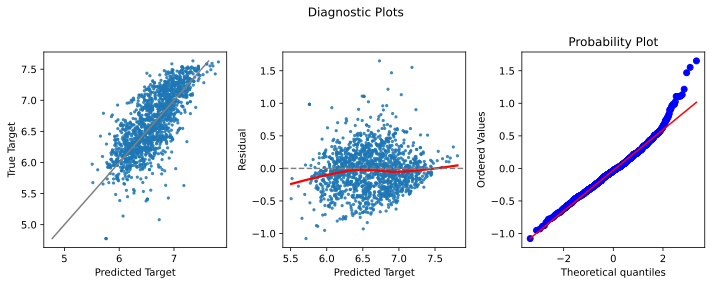

In [477]:
fit_tr = lm.fit(X_tr,y_tr)
fit_val = lm.fit(X_val,y_val)
diagnostic_plots(fit_tr.predict(X_tr), y_tr, fit_tr.predict(X_tr)-y_tr)

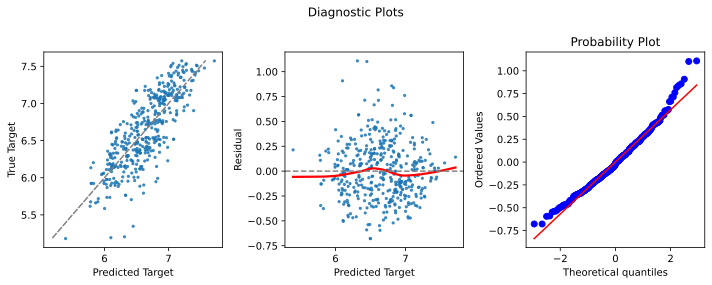

In [478]:
diagnostic_plots(fit_val.predict(X_val), y_val, fit_val.predict(X_val)-y_val)

<AxesSubplot:xlabel='salary_log', ylabel='Count'>

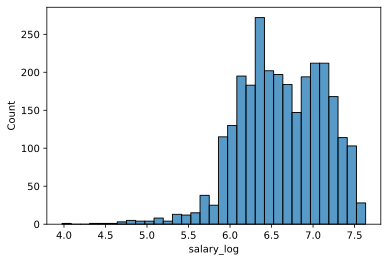

In [479]:
# sns.histplot(dfd.salary_usd)
sns.histplot(dfd.salary_log)

# Feature selection & reduction

In [480]:
def build_grid_search_est(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
#       plt.plot(np.log(df.alpha), df.mean_test_score);
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

In [481]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

Lasso Grid Search


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.22755517690113, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.452513389518856, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.95259362606423, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9540757001183806, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.630545165759528, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.093875489149781, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

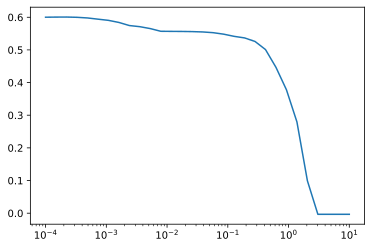

In [482]:
print("Lasso Grid Search")
lasso_grid_est = build_grid_search_est(Lasso(), X_tr, y_tr, cv=kfold,
                                       alpha=np.logspace(-4, 1, 30))

Ridge Grid Search


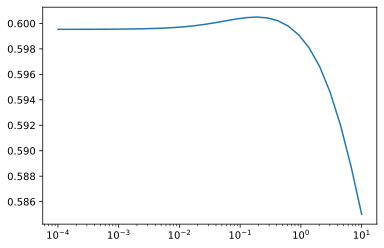

In [483]:
print("Ridge Grid Search")
ridge_grid_est = build_grid_search_est(Ridge(), X_tr, y_tr, cv=kfold,
                                       alpha=np.logspace(-4, 1, 30))

Elastic Net Grid Search


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.269755009142656, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.19849564548535, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.35573761456642, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.62461982268393, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.720800280648184, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.183709537583425, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.32852352892591, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.181786264896076, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.15588237552461, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.32620226250286, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.33430687520687, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.883461946627314, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.71846697619696, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.61277461483721, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.59498195276829, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.39333396129453, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.3418027274653, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.4931968127686, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_mod

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.785993728467695, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.71974844847355, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.149633949463286, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.1296412878933, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.449137793157924, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.499131969192575, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.862086652360404, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.05351829359204, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.21158525120937, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.386263402811174, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.09870745364693, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.145304681139926, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.161245333553666, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.58659736182754, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.452115776039854, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.22827852304432, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.66387837898938, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.728317855382585, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.52424917258254, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.79345342101791, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.8785286684939, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.57440810004813, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.56716558738169, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.04269464908197, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.766796304006064, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.31951394423926, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.074704235440535, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.9798828330721, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.29991578943377, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.34174376331515, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.30891883779094, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.74269780086442, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.969619906658906, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.553311975349715, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.98177648674353, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.73196778441968, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.188072010256256, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.4458383473107, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.6981768731414, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_mo

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.436554840245847, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.542839547724768, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.424397257028552, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/line

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.41562396011556, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.59074542806569, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.050660249032745, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.92542061674568, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.94671146795251, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.971794773606426, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.374287366657356, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.98354628002926, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.179242218244497, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.450978749820045, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.669298411999897, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.36563525034485, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.187799513271536, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.2536004748181, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.665695612890516, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.22450146954021, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.46910202768909, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.952515913113345, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.19950708571234, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.69371888075011, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.924223678948643, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.233672469447008, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.726603331899234, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.737550232286175, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.082268481839797, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.096824701737532, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.191348687953194, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.31216447420813, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.80873111838295, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.70048914376197, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.292265424851195, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.65155872653058, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.997876925250814, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.02559691254445, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.361153753242974, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.417965400195314, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.721164734164319, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.821120991541349, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.587841503669338, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.965144189380382, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.216249795600433, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7548920923045728, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.904762268942214, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.815843263060714, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.556706637147855, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.332990448406719, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.880529283773967, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.169716352744146, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.308992546704161, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.507674908024384, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.035423840312987, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.878653699686893, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.659135152327181, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5751811653954633, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.46253701878572, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.745241880589845, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.82266720272289, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.70879217132574, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5877751105907265, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.438543778945188, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4211206316736735, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3031726087958617, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.256727019474212, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linea

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7254229580773739, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.28057987927221, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4275183808253189, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.21668330497444, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.60384477477585, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.724082860653695, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.964567340821503, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.374167653360104, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.346497332396311, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6850976747726065, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.342989228980059, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8659622938421592, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3759672037585915, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24479753945291804, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1443130172080771, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/line

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.832928619910518, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.668453569072199, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.603653470018003, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05698200326823155, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0998366475062085, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08858069694549897, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/lin

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.791471258853761, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.650199076596749, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.953898851486727, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.6254315420778, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.08834706730724, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.74372657356942, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_mo

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.24890185966129, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.62097834237689, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.19090222801819, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0205204284793865, tolerance: 0.031924661674261647
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2873759513264815, tolerance: 0.03142052445673294
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.039466386529767306, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/li

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.46927037641626, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.59966737703994, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.85807084553848, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.05270704666009, tolerance: 0.03206573062604283
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.04336183284293, tolerance: 0.03240486199922529
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.30570833164002, tolerance: 0.03137804382889883
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

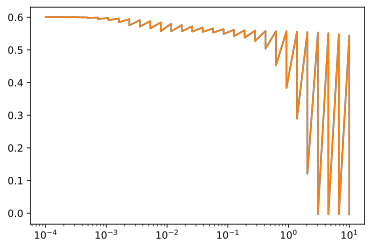

In [484]:
print("Elastic Net Grid Search")
elastic_net_grid_est = build_grid_search_est(ElasticNet(), X_tr, y_tr, cv=kfold,
                                             alpha=np.logspace(-4, 1, 30),
                                             l1_ratio=np.linspace(0,1,30,endpoint=False))

In [485]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = lm.predict(X_val)
print("Linear Regression:", r2_score(y_val, y_pred))

y_pred = lasso_grid_est.predict(X_val)
print("Lasso Regression:", r2_score(y_val, y_pred))

y_pred = ridge_grid_est.predict(X_val)
print("Ridge Regression:", r2_score(y_val, y_pred))

y_pred = elastic_net_grid_est.predict(X_val)
print("ElasticNet Regression:", r2_score(y_val, y_pred))

Linear Regression: 0.6548366215462078
Lasso Regression: 0.616128937008148
Ridge Regression: 0.621669759137687
ElasticNet Regression: 0.6161898632845982


In [486]:
lmcoef = pd.DataFrame(list(zip(X.columns, lm.coef_)), columns=["predvar","lm"])
lassocoef = pd.DataFrame(list(zip(X.columns, lasso_grid_est.best_estimator_.coef_)), columns=["predvar","lasso"])
ridgecoef = pd.DataFrame(list(zip(X.columns, ridge_grid_est.best_estimator_.coef_)), columns=["predvar","ridge"])
elasticcoef = pd.DataFrame(list(zip(X.columns, elastic_net_grid_est.best_estimator_.coef_)), columns=["predvar","elast"])

coefdf = lmcoef.merge(lassocoef, on=["predvar"], how='left').merge(ridgecoef, on=["predvar"], how='left').merge(elasticcoef, on=["predvar"], how='left')
coefdf

,predvar,lm,lasso,ridge,elast
0,age,-1.123332e+12,0.043356,0.035100,0.043389
1,gameplayed,-1.220703e-03,-0.000018,0.000024,-0.000018
2,minpergame,2.934265e-02,0.023660,0.023388,0.023658
3,efgpct,-1.267475e+00,-0.858020,-0.892242,-0.858731
4,ftpct,-3.646013e-01,-0.334827,-0.347462,-0.334885
5,height_in,2.336884e-02,0.020247,0.019336,0.020214
6,wl_pct,-3.156226e-01,-0.000000,-0.068092,-0.000000
7,pts_pg,7.329559e-02,0.065530,0.079767,0.065690
8,opp_pts_pg,-5.659485e-02,-0.052366,-0.066462,-0.052526
9,simple_rating,-3.899002e-02,-0.050282,-0.062587,-0.050445


In [487]:
# sns.pairplot(data=dfmain[:500])

In [488]:
# the reduced set of features
df2 = dfmain[["age",'gameplayed','minpergame','efgpct','ftpct','height_in','pts_pg','opp_pts_pg',\
            'simple_rating','playoff_record','min_interact','age_young','age_mid','age_exp','age_vet',\
            'drpmin','ptpmin','aspmin','pfpmin','salary_log']]

In [489]:
# df2.to_csv('df2.csv')

# Excursus: Polynomial Regression

In [490]:
from sklearn.preprocessing import PolynomialFeatures

In [491]:
X_train, X, y_train, y = train_test_split(df2.drop(['salary_log'],axis=1), df2['salary_log']\
                                          , test_size=0.2, random_state=27)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=34)  

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_tr_poly = poly.fit_transform(X_tr)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_tr_poly,y_tr)
lr_poly.score(X_tr_poly,y_tr)

0.7109918300005802

In [492]:
lr_poly.score(X_val_poly, y_val)

0.6566932827711847

In [493]:
# Overfit

In [494]:
print(dict(zip(X_val.columns,lr_poly.coef_)))

{'age': -4.0866156188816955e-10, 'gameplayed': -701947778.7688873, 'minpergame': 0.05144891476396537, 'efgpct': -0.13541692568517338, 'ftpct': 5.570020288346651, 'height_in': -1.6557646644858057, 'pts_pg': -0.1874899781280349, 'opp_pts_pg': 2.58069704721487, 'simple_rating': -2.4835004356790904, 'playoff_record': -2.4291545003077517, 'min_interact': -0.11903814385130304, 'age_young': -0.09030125768198606, 'age_mid': 701947779.7268065, 'age_exp': 701947779.403056, 'age_vet': 701947779.3848178, 'drpmin': 701947779.478669, 'ptpmin': 7.586740322726356, 'aspmin': 8.834778328606268, 'pfpmin': -2.099980405831485}


# Comparing OLS & regularization outputs

In [495]:
# Check on the multicollinearity issue - needs ridge and/or lasso regularization
# Drop defensive rebounds per min, but keep the interaction features (ignore p-val)
model = sm.OLS(y_train, X_train) 
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             salary_log   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.691e+04
Date:                Thu, 30 Sep 2021   Prob (F-statistic):                        0.00
Time:                        23:05:01   Log-Likelihood:                         -476.97
No. Observations:                2132   AIC:                                      989.9
Df Residuals:                    2114   BIC:                                      1092.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
age                0.0412      0.004     10.128      0.000       0.033       0.049
gameplayed         0.0004      0.000      0.983      0.326      -0.000       0.001
minpergame         0.0255      0.001     17.868      0.000       0.023       0.028
efgpct            -1.1300      0.135     -8.372      0.000      -1.395      -0.865
ftpct             -0.3233      0.073     -4.449      0.000      -0.466      -0.181
height_in          0.0440      0.002     21.376      0.000       0.040       0.048
pts_pg             0.0713      0.020      3.627      0.000       0.033       0.110
opp_pts_pg        -0.0539      0.019     -2.766      0.006      -0.092      -0.016
simple_rating     -0.0529      0.020     -2.648      0.008      -0.092      -0.014
playoff_record    -0.0019      0.001     -2.394      0.017      -0.004      -0.000
min_interact       0.0005      0.001      0.563      0.574      -0.001       0.002
age_young          0.0117      0.002      5.198      0.000       0.007       0.016
age_mid            0.0098      0.001      7.072      0.000       0.007       0.013
age_exp            0.0118      0.001     16.185      0.000       0.010       0.013
age_vet            0.0079      0.001     10.988      0.000       0.007       0.009
drpmin            -0.1154      0.161     -0.719      0.472      -0.430       0.199
ptpmin             0.5722      0.066      8.670      0.000       0.443       0.702
aspmin             1.2453      0.135      9.198      0.000       0.980       1.511
pfpmin            -1.7249      0.309     -5.588      0.000      -2.330      -1.120
==============================================================================
Omnibus:                      239.841   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.455
Skew:                          -0.676   Prob(JB):                    1.07e-115
Kurtosis:                       5.033   Cond. No.                     1.91e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.98e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### LASSO CV again and final set of predictor variables

In [496]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_tr.values, y_tr)
    
    val_set_pred = pipe.predict(X_val.values)
    err_vec_val[i] = mae(y_val, val_set_pred)

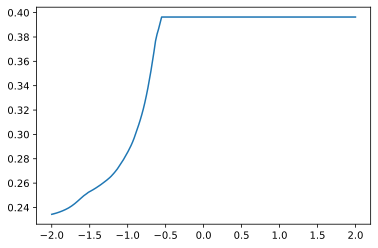

In [497]:
plt.plot(np.log10(alphalist), err_vec_val)

In [498]:
np.min(err_vec_val)

0.234383412155072

In [499]:
alphalist[np.argmin(err_vec_val)]

0.01

In [500]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [501]:
X_tr_std = std.transform(X_tr.values)
X_std = std.transform(X.values)

In [502]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_std, y)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [503]:
lasso_model.alpha_

0.01

In [504]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X.columns, lasso_model.coef_))

[('age', 0.14428656822836294),
 ('gameplayed', -0.0),
 ('minpergame', 0.2039940651659479),
 ('efgpct', -0.0038323966295667903),
 ('ftpct', -0.016747092926621056),
 ('height_in', -0.0),
 ('pts_pg', 0.06711891093797301),
 ('opp_pts_pg', 0.016750974142496648),
 ('simple_rating', -0.0),
 ('playoff_record', -0.0),
 ('min_interact', -0.015432672492507444),
 ('age_young', -0.0),
 ('age_mid', -0.0018630847274787794),
 ('age_exp', 0.034681238335455326),
 ('age_vet', 0.0),
 ('drpmin', 0.010377419036419915),
 ('ptpmin', 0.08650652098972632),
 ('aspmin', 0.0),
 ('pfpmin', -0.04485503432846291)]

In [505]:
df2.corr()>0.5

,age,gameplayed,minpergame,efgpct,ftpct,height_in,pts_pg,opp_pts_pg,simple_rating,playoff_record,min_interact,age_young,age_mid,age_exp,age_vet,drpmin,ptpmin,aspmin,pfpmin,salary_log
age,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False
gameplayed,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
minpergame,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
efgpct,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ftpct,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
height_in,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
pts_pg,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
opp_pts_pg,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
simple_rating,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
playoff_record,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False


### Cross check with LARS path

In [506]:
X_tr, X, y_tr, y = train_test_split(df2.drop(['salary_log'],axis=1), df2['salary_log'], test_size=0.2, random_state=27)

std = StandardScaler()
std.fit(X_tr.values)
X_tr_tr = std.transform(X_tr.values)

In [507]:
print("Computing regularization path using the LARS ...")
alphas, order, coefs = lars_path(X_tr_tr, y_tr.values, method='lasso')

Computing regularization path using the LARS ...


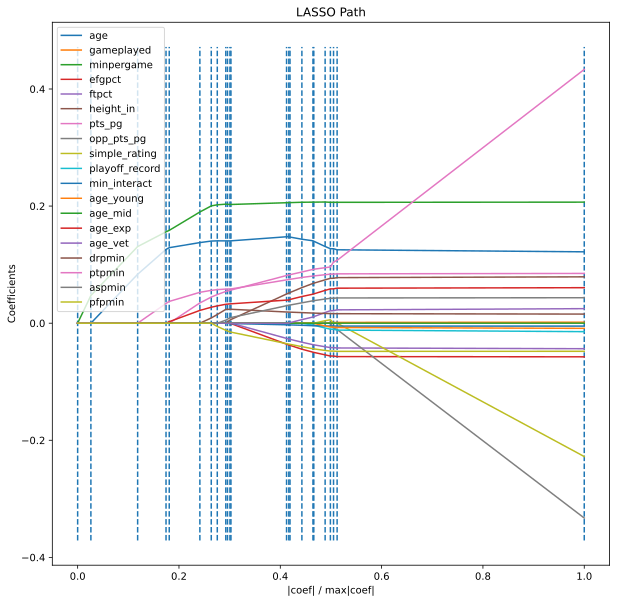

In [508]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr.columns) # look at the row below
plt.show()

In [509]:
names1 = []
for i in order:
    placeholder = X_tr.columns
    names1.append(placeholder[i])
names1

['minpergame',
 'age',
 'ptpmin',
 'age_exp',
 'pts_pg',
 'drpmin',
 'pfpmin',
 'aspmin',
 'height_in',
 'min_interact',
 'efgpct',
 'ftpct',
 'age_vet',
 'playoff_record',
 'age_young',
 'gameplayed',
 'opp_pts_pg',
 'simple_rating']

# Final fit and test

In [614]:
X_tr, X, y_tr, y = train_test_split(df2.drop(['pts_pg','simple_rating','salary_log'],axis=1), df2['salary_log'], test_size=0.2, random_state=27)

In [511]:
def finalfits(model, X, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, scoring='neg_mean_absolute_error',
                            return_train_score=False)
    grid_est.fit(X, y)
    return grid_est

lm_f = finalfits(lm, X_tr, y_tr, cv=kfold)    
lasso_f = finalfits(Lasso(), X_tr, y_tr, cv=kfold, alpha=np.logspace(-2, 1, 30))
ridge_f = finalfits(Ridge(), X_tr, y_tr, cv=kfold, alpha=np.logspace(-2, 1, 30))
en_f = finalfits(ElasticNet(), X_tr, y_tr, cv=kfold, alpha=np.logspace(-2, 1, 30),\
                                             l1_ratio=np.linspace(0,1,30,endpoint=False))

lm_pred = lm_f.predict(X)
print("Linear Regression:", '\t',f'{r2_score(y, lm_pred):.4f}', '\t', f'{10**mean_squared_error(y, lm_pred):.1f}')

la_pred = lasso_f.predict(X)
print("Lasso Regression:", '\t',f'{r2_score(y, la_pred):.4f}', '\t', f'{10**mean_squared_error(y, la_pred):.1f}')

r_pred = ridge_f.predict(X)
print("Ridge Regression:", '\t',f'{r2_score(y, r_pred):.4f}', '\t', f'{10**mean_squared_error(y, r_pred):.1f}')

e_pred = en_f.predict(X)
print("ElasticNet Regression:", '\t', f'{r2_score(y, e_pred):.4f}', '\t', f'{10**mean_squared_error(y, e_pred):.1f}')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.27710739494388, tolerance: 0.03941168160020716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.26105765882608, tolerance: 0.04039598081726962
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.43087544781675, tolerance: 0.04090875870650047
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.062974955134166, tolerance: 0.04039598081726962
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8785092281220557, tolerance: 0.04090875870650047
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.29436374127457, tolerance: 0.03941168160020716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.45169700518083, tolerance: 0.03941168160020716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.56727231577214, tolerance: 0.04039598081726962
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.53857713145237, tolerance: 0.04090875870650047
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.3053238496515, tolerance: 0.03941168160020716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.4493038731414, tolerance: 0.04039598081726962
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.35215011999514, tolerance: 0.04090875870650047
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_mod

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.71570578842268, tolerance: 0.03941168160020716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.92818247857008, tolerance: 0.04039598081726962
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.78394618115237, tolerance: 0.04090875870650047
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_m

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.8996289044244, tolerance: 0.03941168160020716
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.3370270748223, tolerance: 0.04039598081726962
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.1020592837809, tolerance: 0.04090875870650047
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_mode

Linear Regression: 	 0.6066 	 1.2
Lasso Regression: 	 0.5618 	 1.3
Ridge Regression: 	 0.6063 	 1.2
ElasticNet Regression: 	 0.5856 	 1.2


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.71274978630632, tolerance: 0.05015493878151805
  model = cd_fast.enet_coordinate_descent(


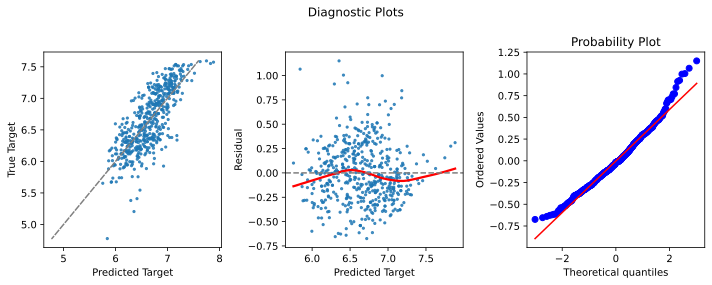

In [512]:
diagnostic_plots(lm_pred, y, lm_pred-y)

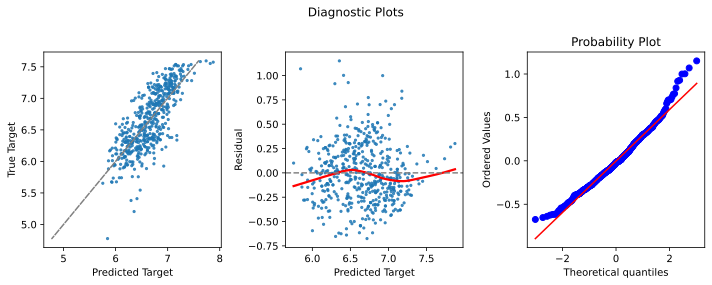

In [513]:
diagnostic_plots(r_pred, y, r_pred-y)

In [566]:
outputdf = pd.DataFrame(ridge_f.cv_results_)

In [515]:
X["actual"] = 10**y
X["ridge_pred"] = 10**r_pred
X["lm_pred"] = 10**lm_pred
X["act_vs_lm"] = X["actual"] - X["lm_pred"]

In [556]:
dfregrets = X.merge(df[["player_name","season",'team']], how='left', left_index=True, right_index=True)

In [574]:
ridge_f.best_estimator_.coef_

array([ 3.01224116e-02,  4.77150170e-04,  2.21228030e-02, -7.32988637e-01,
       -3.81933795e-01,  2.16871266e-02,  1.06150220e-02,  2.26392529e-03,
       -1.31554528e-03,  4.39723615e-03,  5.81262842e-03,  1.07995750e-02,
        9.11297179e-03,  3.10527089e-01,  6.97883974e-01,  7.29714394e-01,
       -1.61221649e+00])

In [576]:
X_tr.columns

Index(['age', 'gameplayed', 'minpergame', 'efgpct', 'ftpct', 'height_in',
       'opp_pts_pg', 'playoff_record', 'min_interact', 'age_young', 'age_mid',
       'age_exp', 'age_vet', 'drpmin', 'ptpmin', 'aspmin', 'pfpmin'],
      dtype='object')

In [589]:
ridge_out = pd.DataFrame(ridge_f.best_estimator_.coef_,np.array(X_tr.columns),columns=['coef'])

<AxesSubplot:>

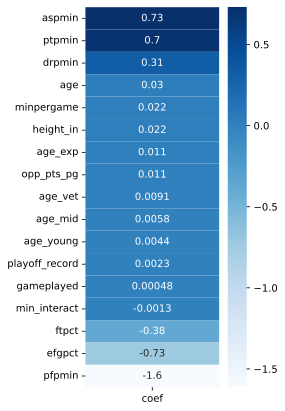

In [608]:
coefin = ridge_out.sort_values(by="coef", ascending=False)

coefin10 = np.array(10**coefin)

fig, ax = plt.subplots(figsize=(3,7))
sns.heatmap(data=coefin, annot=True, cmap="Blues", ax=ax)

In [602]:
ridge_out

,coef
aspmin,0.729714
ptpmin,0.697884
drpmin,0.310527
age,0.030122
minpergame,0.022123
height_in,0.021687
age_exp,0.010800
opp_pts_pg,0.010615
age_vet,0.009113
age_mid,0.005813


In [616]:
poly = PolynomialFeatures(degree=2)
X_tr_poly = poly.fit_transform(X_tr)
X_poly = poly.transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_tr_poly,y_tr)
lr_poly.score(X_poly,y)

0.6745890202221954

In [620]:
10**mae(y, lr_poly.predict(X_poly))

1.615338432877383

In [624]:
df.describe()

,season,age,gameplayed,gamestarted,minpergame,fgmade,fgattempt,fgpct,threemade,threeattempt,threepct,twomade,twoattempt,twopct,efgpct,ftmade,ftattempt,ftpct,offreb,defreb,allreb,assist,steals,blocks,turnov,pfouls,points,height_in,weight_lbs,salary_usd
count,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2791.000000,2.791000e+03
mean,2016.835185,25.035113,56.954855,34.290577,24.963669,4.191437,9.054568,0.462387,0.967216,2.715801,0.297172,3.225331,6.338767,0.506564,0.514612,1.935149,2.556754,0.740504,1.109925,3.528234,4.634540,2.622931,0.842709,0.519993,1.480688,2.006664,11.282336,78.534934,219.825511,7.543609e+06
std,3.697145,3.729979,22.088226,29.782228,8.577511,2.233022,4.722821,0.079369,0.849759,2.205153,0.137489,1.974566,3.806863,0.083545,0.072989,1.569197,1.982749,0.137028,0.875831,1.922522,2.632757,2.178413,0.460648,0.480145,0.867363,0.692581,6.274460,3.376725,26.609482,7.907872e+06
min,2004.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,160.000000,9.474000e+03
25%,2015.000000,22.000000,43.000000,4.000000,18.700000,2.500000,5.400000,0.421000,0.200000,0.700000,0.269000,1.700000,3.400000,0.463000,0.480000,0.800000,1.100000,0.688000,0.500000,2.200000,2.800000,1.000000,0.500000,0.200000,0.800000,1.600000,6.500000,76.000000,197.000000,1.864620e+06
50%,2018.000000,25.000000,63.000000,26.000000,26.300000,3.800000,8.300000,0.452000,0.800000,2.400000,0.336000,2.800000,5.600000,0.503000,0.514000,1.500000,2.000000,0.767000,0.800000,3.200000,4.100000,1.900000,0.800000,0.400000,1.300000,2.000000,10.200000,79.000000,220.000000,4.062000e+06
75%,2020.000000,28.000000,76.000000,64.000000,32.050000,5.600000,12.300000,0.498000,1.500000,4.200000,0.375000,4.400000,8.600000,0.546000,0.550000,2.500000,3.400000,0.824000,1.400000,4.500000,5.800000,3.600000,1.100000,0.600000,1.900000,2.500000,15.000000,81.000000,240.000000,1.130000e+07
max,2021.000000,40.000000,82.000000,82.000000,42.500000,11.200000,24.500000,1.000000,5.300000,13.200000,1.000000,10.200000,20.400000,1.000000,1.000000,10.200000,11.800000,1.000000,5.400000,11.400000,16.000000,11.700000,2.800000,3.700000,5.700000,4.900000,36.100000,88.000000,290.000000,4.300636e+07


In [625]:
dfd.iloc[500:550]

,player_name,height,weight,season,age,team,pos,gameplayed,gamestarted,minpergame,fgmade,fgattempt,fgpct,threemade,threeattempt,threepct,twomade,twoattempt,twopct,efgpct,ftmade,ftattempt,ftpct,offreb,defreb,allreb,assist,steals,blocks,turnov,pfouls,points,salary,height_in,weight_lbs,salaryusd,salary_usd,MVP,ROTY,PTS,REBS,ASS,WINSHARES,wl_pct,pts_pg,opp_pts_pg,simple_rating,champ,finals,conf_fin,conf_semi,conf_first,def_stat,off_eff,starter,salary_log,playoff_record,shotsmade
500,Julius Randle,6-8,250lb,2020.0,25.0,NYK,PF,64.0,64.0,32.5,7.2,15.7,0.460,1.0,3.6,0.277,6.2,12.1,0.515,0.492,4.0,5.5,0.733,2.4,7.4,9.7,3.1,0.8,0.3,3.0,2.8,19.5,"$18,000,000",80,250,"18,000,000",18000000,0.0,0.0,0.0,0.0,0.0,0.0,0.318,105.8,112.3,-6.72,0.0,0.0,0.0,0.0,0.0,1.1,7.3,1.000000,7.255273,0.0,11.70
501,Julius Randle,6-8,250lb,2021.0,26.0,NYK,PF,71.0,71.0,37.6,8.5,18.6,0.456,2.3,5.5,0.411,6.2,13.1,0.474,0.516,4.9,6.0,0.811,1.2,9.0,10.2,6.0,0.9,0.3,3.4,3.2,24.1,"$18,900,000",80,250,"18,900,000",18900000,0.0,0.0,0.0,0.0,0.0,0.0,0.569,107.0,104.7,2.13,0.0,0.0,0.0,0.0,1.0,1.2,11.1,1.000000,7.276462,1.0,14.55
502,Lonzo Ball,6-6,190lb,2018.0,20.0,LAL,PG,52.0,50.0,34.2,3.9,10.8,0.360,1.7,5.7,0.305,2.2,5.2,0.420,0.440,0.6,1.4,0.451,1.3,5.6,6.9,7.2,1.7,0.8,2.6,2.3,10.2,"A$6,286,560",78,190,"6,286,560",6286560,0.0,0.0,0.0,0.0,0.0,0.0,0.427,108.1,109.6,-1.44,0.0,0.0,0.0,0.0,0.0,2.5,8.5,0.961538,6.798413,0.0,5.35
503,Lonzo Ball,6-6,190lb,2019.0,21.0,LAL,PG,47.0,45.0,30.3,3.9,9.7,0.406,1.6,4.9,0.329,2.3,4.9,0.482,0.488,0.4,1.0,0.417,1.1,4.2,5.3,5.4,1.5,0.4,2.2,2.4,9.9,"A$7,461,960",78,190,"7,461,960",7461960,0.0,0.0,0.0,0.0,0.0,0.0,0.451,111.8,113.5,-1.33,0.0,0.0,0.0,0.0,0.0,1.9,7.1,0.957447,6.872853,0.0,5.10
504,Lonzo Ball,6-6,190lb,2020.0,22.0,NOP,PG,63.0,54.0,32.1,4.4,10.9,0.403,2.3,6.3,0.375,2.0,4.6,0.442,0.511,0.7,1.2,0.566,1.1,5.0,6.1,7.0,1.4,0.6,3.1,2.0,11.8,"A$8,719,320",78,190,"8,719,320",8719320,0.0,0.0,0.0,0.0,0.0,0.0,0.417,115.8,117.1,-0.55,0.0,0.0,0.0,0.0,0.0,2.0,8.3,0.857143,6.940483,0.0,6.15
505,Lonzo Ball,6-6,190lb,2021.0,23.0,NOP,PG,55.0,55.0,31.8,5.3,12.7,0.414,3.1,8.3,0.378,2.1,4.5,0.482,0.537,0.9,1.2,0.781,0.6,4.2,4.8,5.7,1.5,0.6,2.2,1.9,14.6,"$11,003,782",78,190,"11,003,782",11003782,0.0,0.0,0.0,0.0,0.0,0.0,0.431,114.6,114.9,-0.20,0.0,0.0,0.0,0.0,0.0,2.1,8.8,1.000000,7.041542,0.0,7.65
506,Fred VanVleet,6-1,197lb,2017.0,22.0,TOR,PG,37.0,0.0,7.9,1.1,3.0,0.351,0.3,0.8,0.379,0.8,2.2,0.341,0.401,0.5,0.6,0.818,0.1,1.0,1.1,0.9,0.4,0.1,0.4,1.0,2.9,"NBA$543,471",73,197,"543,471",543471,0.0,0.0,0.0,0.0,0.0,0.0,0.622,106.9,102.6,3.65,0.0,0.0,0.0,0.0,4.0,0.5,1.6,0.000000,5.735176,4.0,1.75
507,Fred VanVleet,6-1,197lb,2018.0,23.0,TOR,PG,76.0,0.0,20.0,3.1,7.2,0.426,1.4,3.4,0.414,1.6,3.7,0.437,0.525,1.1,1.3,0.832,0.3,2.1,2.4,3.2,0.9,0.3,1.0,1.7,8.6,"A$1,312,611",73,197,"1,312,611",1312611,0.0,0.0,0.0,0.0,0.0,0.0,0.720,111.7,103.9,7.29,0.0,0.0,0.0,0.0,4.0,1.2,5.3,0.000000,6.118136,4.0,4.80
508,Fred VanVleet,6-1,197lb,2019.0,24.0,TOR,PG,64.0,28.0,27.5,3.8,9.4,0.410,1.8,4.6,0.378,2.1,4.8,0.441,0.503,1.5,1.8,0.843,0.3,2.3,2.6,4.8,0.9,0.3,1.3,1.7,11.0,"A$8,653,847",73,197,"8,653,847",8653847,0.0,0.0,0.0,0.0,0.0,0.0,0.707,114.4,108.4,5.49,1.0,4.0,4.0,4.0,4.0,1.2,7.3,0.437500,6.937209,40.0,6.30
509,Fred VanVleet,6-1,197lb,2020.0,25.0,TOR,SG,54.0,54.0,35.7,5.9,14.3,0.413,2.7,6.9,0.390,3.2,7.4,0.434,0.507,3.1,3.7,0.848,0.3,3.4,3.8,6.6,1.9,0.3,2.2,2.4,17.6,"A$9,346,153",73,197,"9,346,153",9346153,0.0,0.0,0.0,0.0,0.0,0.0,0.736,112.8,106.5,5.97,0.0,0.0,0.0,3.0,4.0,2.2,10.3,1.000000,6.970633,10.0,10.35
